In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.1 cuda: True


In [2]:
## Load dataset
data_path = "../../../rings_fixed_radius"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()
FIXED_RADIUS = 1.5

NUM_DATASETS, N, D = Data.shape
K = 3 ## number of clusters
SAMPLE_SIZE = 10
NUM_HIDDEN_GLOBAL = 8
NUM_HIDDEN_LOCAL = 64
NUM_STATS = 16

MCMC_SIZE = 10
BATCH_SIZE = 20
NUM_EPOCHS = 250
LEARNING_RATE = 1e-4
PRIOR_FLAG = False
ONLY_FORWARD = True
CUDA = torch.cuda.is_available()
PATH = 'ep-onlyf-%dsteps-%dsamples' % (MCMC_SIZE, SAMPLE_SIZE)
DEVICE = torch.device('cuda:1')

obs_rad = torch.ones(1) * FIXED_RADIUS
noise_sigma = torch.ones(1) * 0.05
if CUDA:
    obs_rad = obs_rad.cuda().to(DEVICE)
    noise_sigma = noise_sigma.cuda().to(DEVICE)
Train_Params = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)
Model_Params = (obs_rad, noise_sigma, N, K, D, MCMC_SIZE, PRIOR_FLAG, ONLY_FORWARD)

In [3]:
from local_enc import *
from global_oneshot import *
from global_enc import *
## if reparameterize continuous variables
Reparameterized = False
# initialization
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
enc_eta = Enc_mu(K, D, NUM_HIDDEN_GLOBAL, NUM_STATS, CUDA, DEVICE, Reparameterized)
if CUDA:
    enc_z.cuda().to(DEVICE)
    enc_eta.cuda().to(DEVICE)
if PRIOR_FLAG:
    optimizer =  torch.optim.Adam(list(enc_eta.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
    models = (enc_eta, enc_z)
else:
    oneshot_eta = Oneshot_mu(K, D, NUM_HIDDEN_GLOBAL, NUM_STATS, CUDA, DEVICE, Reparameterized)
    if CUDA:
        oneshot_eta.cuda().to(DEVICE)
    optimizer =  torch.optim.Adam(list(oneshot_eta.parameters())+list(enc_eta.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
    models = (oneshot_eta, enc_eta, enc_z)

In [4]:
from ag_ep import *
train(models, EUBO_init_eta, optimizer, Data, Model_Params, Train_Params)

epoch: 0\250 (172s),  symKL_DB_eta: 649619.747,  symKL_DB_z: 475121.929,  gap_eta: 648528.248,  gap_z: 474758.849,  loss: -361942.212,  ess: 2.588
epoch: 1\250 (172s),  symKL_DB_eta: 409411.399,  symKL_DB_z: 243875.026,  gap_eta: 408793.763,  gap_z: 243590.489,  loss: -222245.073,  ess: 3.475
epoch: 2\250 (170s),  symKL_DB_eta: 307494.975,  symKL_DB_z: 81476.845,  gap_eta: 307423.593,  gap_z: 81264.610,  loss: -142656.844,  ess: 4.165
epoch: 3\250 (167s),  symKL_DB_eta: 205879.683,  symKL_DB_z: 30945.162,  gap_eta: 205856.169,  gap_z: 30788.042,  loss: -92929.878,  ess: 4.543
epoch: 4\250 (168s),  symKL_DB_eta: 125957.161,  symKL_DB_z: 12930.538,  gap_eta: 125935.102,  gap_z: 12818.893,  loss: -67069.382,  ess: 4.767
epoch: 5\250 (167s),  symKL_DB_eta: 89697.672,  symKL_DB_z: 6368.169,  gap_eta: 89696.983,  gap_z: 6283.100,  loss: -46153.529,  ess: 4.892
epoch: 6\250 (168s),  symKL_DB_eta: 70163.839,  symKL_DB_z: 4050.537,  gap_eta: 70161.891,  gap_z: 3986.033,  loss: -31370.593,  ess:

In [6]:
torch.save(enc_z.state_dict(), "../weights/enc-z-%s" % PATH)
torch.save(enc_eta.state_dict(), "../weights/enc-mu-%s" % PATH)
torch.save(oneshot_eta.state_dict(), "../weights/oneshot-mu-%s" % PATH)

In [9]:
BATCH_SIZE_TEST = 50
Train_Params_Test = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, PATH)

obs, metric_step, reused = test(models, EUBO_init_eta, Data, Model_Params, Train_Params_Test)
(q_mu, _, q_z, _) = reused

CPU times: user 4.58 s, sys: 40.1 ms, total: 4.62 s
Wall time: 4.61 s


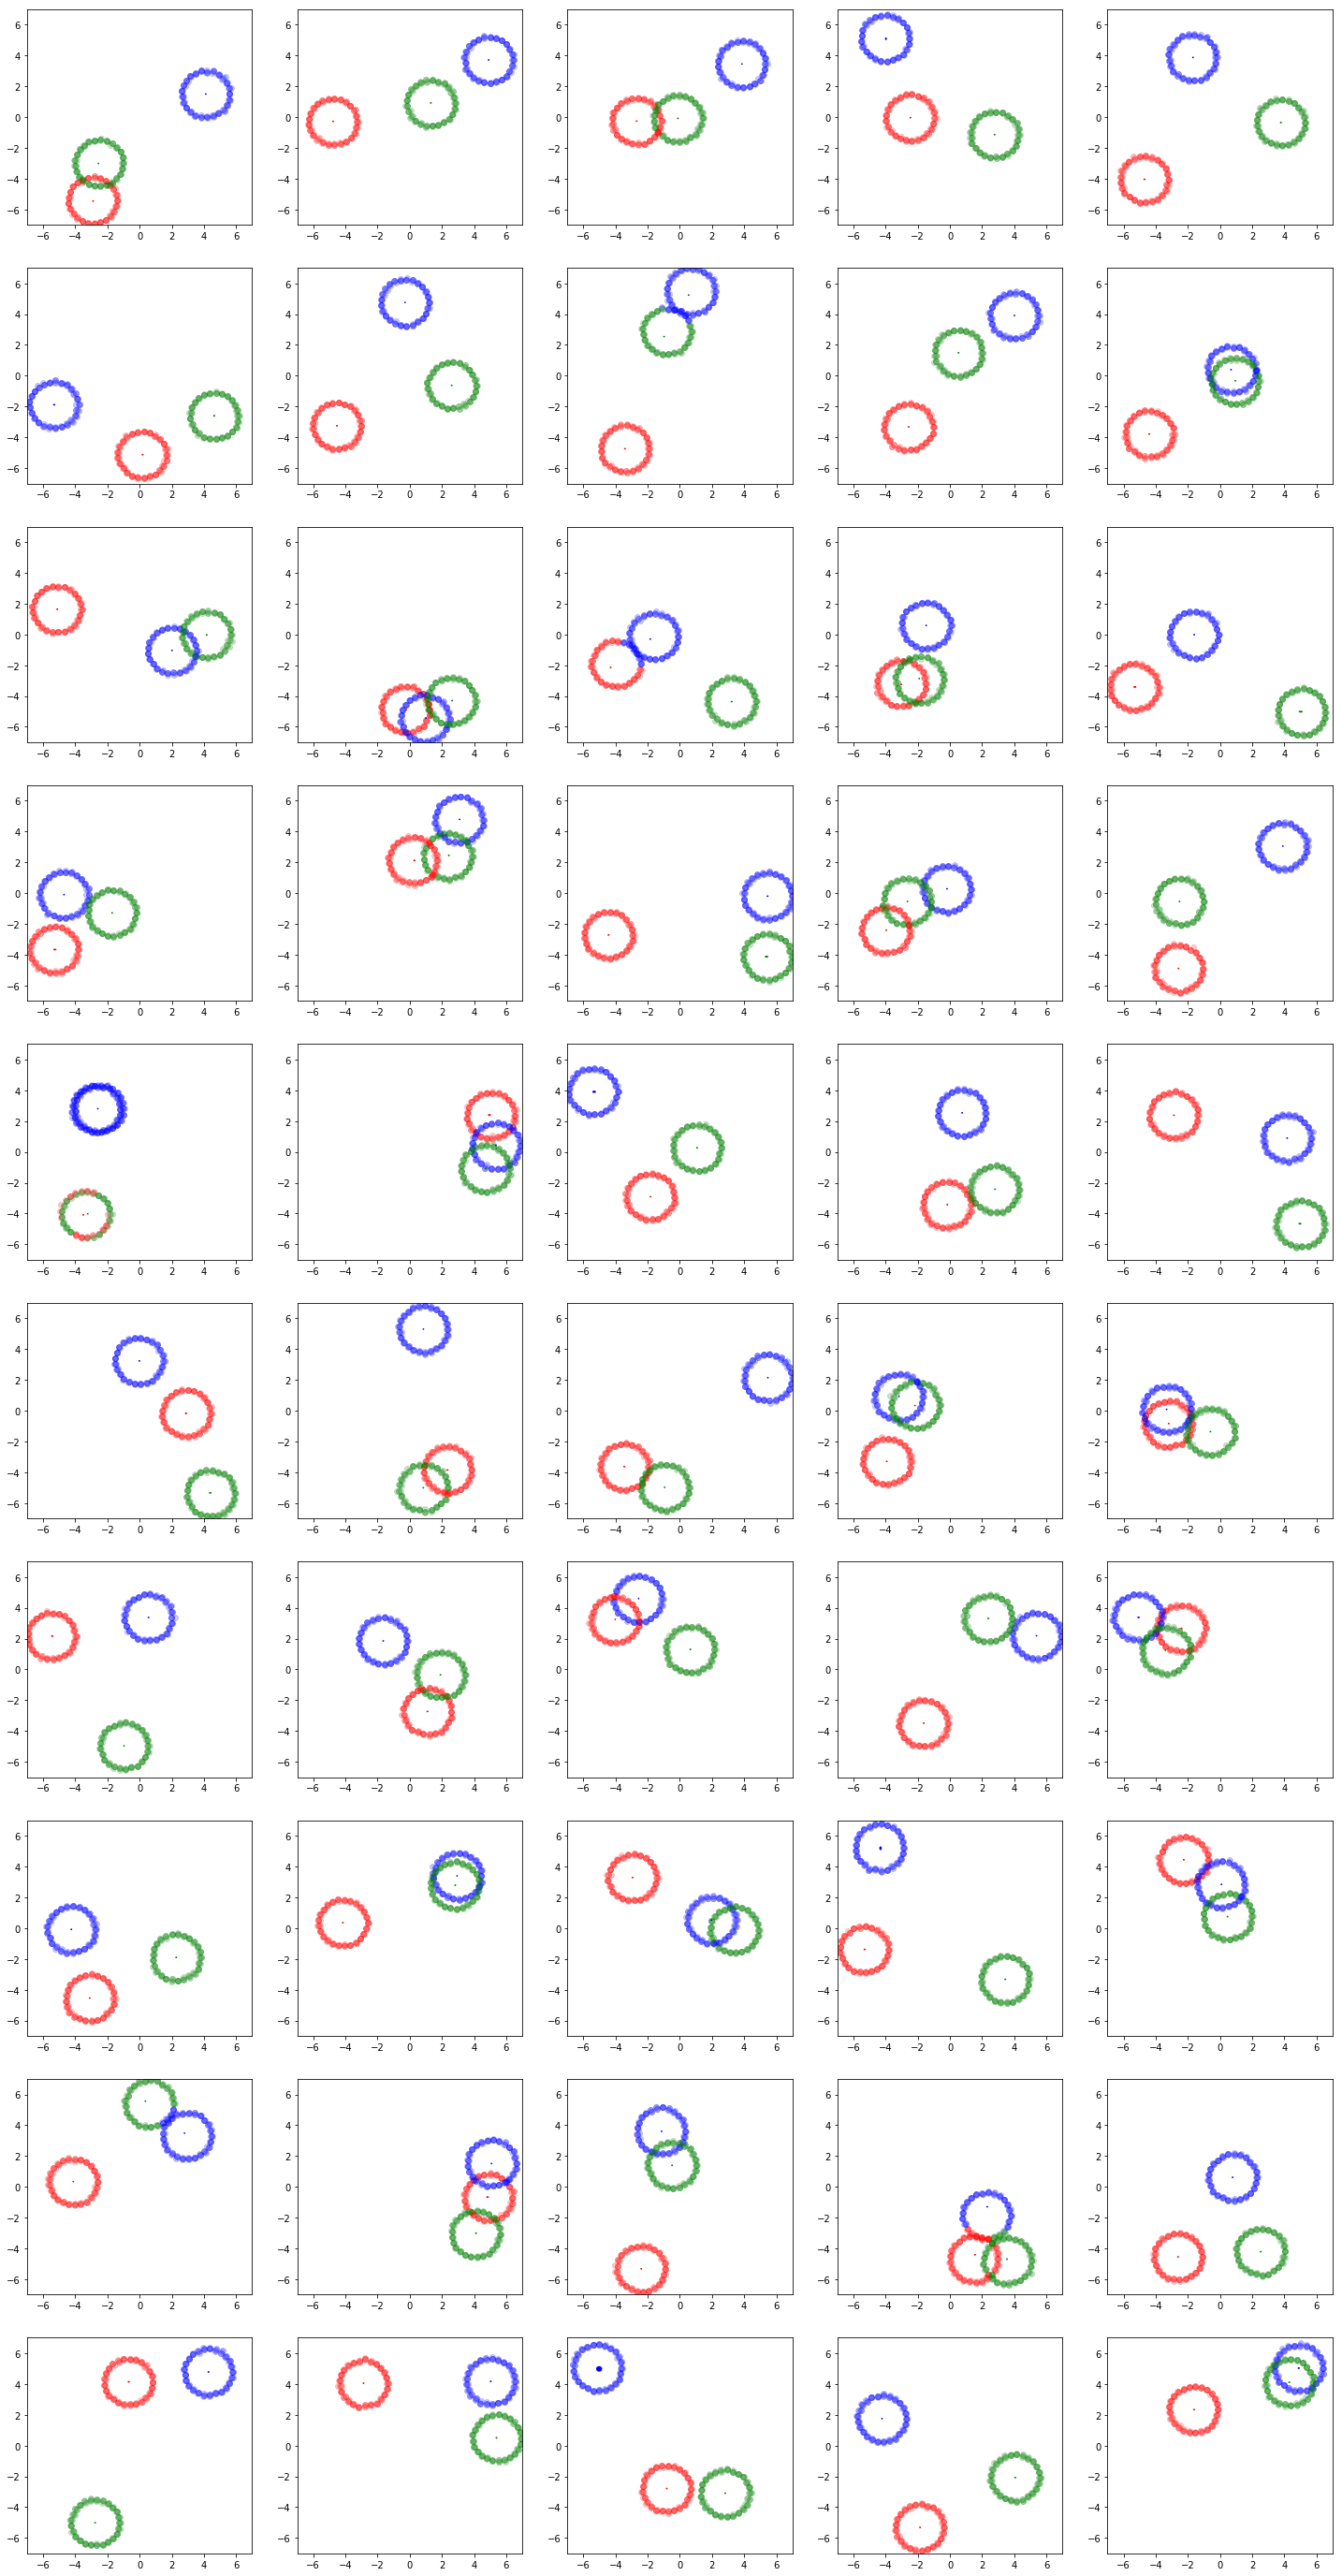

In [10]:
%time plot_samples(obs, q_mu, q_z, K, PATH)

In [ ]:
incremental_gap = symkls_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')